In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Integration and label transfer with Tabula Muris

https://docs.scvi-tools.org/en/stable/tutorials/notebooks/tabula_muris.html
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html

Following the general tutorial on atlas-level integration, here we show using scVI and scANVI for label transfer. 
Fully-labeled reference dataset

Unlabeled query dataset

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/conda/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [4]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8047 sha256=4575aeb120d2ea96ec0fd91345a8629931b681c44c3bc81555a0888ede841674
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [5]:
!pip install scarches

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.0/351.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
from scvi.model.utils import mde

In [11]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [12]:
adata_ref = sc.read('/kaggle/input/myelomareference/local.h5ad')


In [15]:
adata_ref

AnnData object with n_obs × n_vars = 13165 × 30539
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_bothtsne', 'X_bothumap', 'X_mofa', 'X_mofatsne', 'X_mofaumap', 'X_pca', 'X_projected', 'X_projectedmean'

In [16]:
adata_ref.obs['Genotype']

884635    healthy
518328    healthy
392962    healthy
826846    healthy
97453     healthy
           ...   
841282    healthy
564865    healthy
248583    healthy
675416    healthy
411265    healthy
Name: Genotype, Length: 13165, dtype: category
Categories (1, object): ['healthy']

In [17]:
adata_ref = adata_ref.raw.to_adata()

In [18]:
adata_ref.var_names = adata_ref.var.feature_name

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:879: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [19]:
adata_ref.var

,feature_name,feature_reference,feature_biotype
feature_name,,,
A1BG,A1BG,NCBITaxon:9606,gene
A1BG-AS1,A1BG-AS1,NCBITaxon:9606,gene
A1CF,A1CF,NCBITaxon:9606,gene
A2M,A2M,NCBITaxon:9606,gene
A2M-AS1,A2M-AS1,NCBITaxon:9606,gene
...,...,...,...
ZXDC,ZXDC,NCBITaxon:9606,gene
ZYG11A,ZYG11A,NCBITaxon:9606,gene
ZYG11B,ZYG11B,NCBITaxon:9606,gene


In [20]:
del adata_ref.var['feature_name'] #To delete 3rd column

In [21]:
adata_ref.var

,feature_reference,feature_biotype
feature_name,,
A1BG,NCBITaxon:9606,gene
A1BG-AS1,NCBITaxon:9606,gene
A1CF,NCBITaxon:9606,gene
A2M,NCBITaxon:9606,gene
A2M-AS1,NCBITaxon:9606,gene
...,...,...
ZXDC,NCBITaxon:9606,gene
ZYG11A,NCBITaxon:9606,gene
ZYG11B,NCBITaxon:9606,gene


In [22]:
print(adata_ref.X)

  (0, 10)	5.0
  (0, 17)	1.0
  (0, 19)	2.0
  (0, 21)	1.0
  (0, 25)	1.0
  (0, 28)	4.0
  (0, 29)	3.0
  (0, 30)	2.0
  (0, 32)	3.0
  (0, 37)	1.0
  (0, 43)	2.0
  (0, 44)	1.0
  (0, 46)	1.0
  (0, 51)	10.0
  (0, 56)	2.0
  (0, 57)	2.0
  (0, 59)	4.0
  (0, 65)	3.0
  (0, 66)	8.0
  (0, 72)	1.0
  (0, 73)	2.0
  (0, 74)	3.0
  (0, 75)	19.0
  (0, 76)	10.0
  (0, 78)	3.0
  :	:
  (13164, 29762)	1.0
  (13164, 29778)	1.0
  (13164, 29822)	1.0
  (13164, 29826)	1.0
  (13164, 29851)	1.0
  (13164, 29852)	1.0
  (13164, 29872)	1.0
  (13164, 29877)	1.0
  (13164, 29901)	2.0
  (13164, 29932)	1.0
  (13164, 30030)	1.0
  (13164, 30079)	1.0
  (13164, 30102)	1.0
  (13164, 30113)	2.0
  (13164, 30116)	1.0
  (13164, 30133)	1.0
  (13164, 30142)	1.0
  (13164, 30152)	3.0
  (13164, 30201)	1.0
  (13164, 30270)	1.0
  (13164, 30356)	2.0
  (13164, 30448)	1.0
  (13164, 30466)	2.0
  (13164, 30500)	1.0
  (13164, 30536)	1.0


In [23]:
adata_query = sc.read('/kaggle/input/myelomareference/downsample_2000_raw.h5ad')

In [24]:
adata_query

AnnData object with n_obs × n_vars = 30000 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'age', 'gender', 'stage', 'tissue', 'organism', 'treatment', 'study_id', 'sample_id', 'treatment_type', 'substage', 'subID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.01', 'RNA_snn_res.0.001', 'RNA_snn_res.1e.04', 'RNA_snn_res.1e.05', 'RNA_snn_res.5e.04', 'RNA_snn_res.1', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.4'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [25]:
adata_query = adata_query.raw.to_adata()

In [27]:
adata_query

AnnData object with n_obs × n_vars = 30000 × 19203
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'age', 'gender', 'stage', 'tissue', 'organism', 'treatment', 'study_id', 'sample_id', 'treatment_type', 'substage', 'subID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.01', 'RNA_snn_res.0.001', 'RNA_snn_res.1e.04', 'RNA_snn_res.1e.05', 'RNA_snn_res.5e.04', 'RNA_snn_res.1', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.4'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [28]:
print(adata_query.X)

  (0, 21)	2.0
  (0, 103)	1.0
  (0, 181)	1.0
  (0, 330)	1.0
  (0, 341)	1.0
  (0, 346)	2.0
  (0, 358)	1.0
  (0, 388)	3.0
  (0, 430)	1.0
  (0, 441)	5.0
  (0, 446)	1.0
  (0, 450)	1.0
  (0, 464)	1.0
  (0, 475)	1.0
  (0, 479)	3.0
  (0, 498)	1.0
  (0, 502)	1.0
  (0, 638)	1.0
  (0, 660)	2.0
  (0, 789)	1.0
  (0, 801)	1.0
  (0, 826)	1.0
  (0, 829)	1.0
  (0, 834)	1.0
  (0, 856)	1.0
  :	:
  (29999, 16722)	1.0
  (29999, 16754)	1.0
  (29999, 16849)	1.0
  (29999, 17060)	1.0
  (29999, 17079)	4.0
  (29999, 17098)	1.0
  (29999, 17257)	2.0
  (29999, 17362)	6.0
  (29999, 17364)	2.0
  (29999, 17447)	1.0
  (29999, 17491)	1.0
  (29999, 17512)	1.0
  (29999, 17708)	1.0
  (29999, 17745)	1.0
  (29999, 17826)	2.0
  (29999, 17893)	1.0
  (29999, 17953)	1.0
  (29999, 18121)	1.0
  (29999, 18348)	1.0
  (29999, 18414)	1.0
  (29999, 18503)	1.0
  (29999, 18738)	1.0
  (29999, 18745)	1.0
  (29999, 18852)	1.0
  (29999, 18986)	1.0


In [29]:
adata_ref.shape, adata_query.shape

((13165, 30539), (30000, 19203))

In [30]:
pip install anndata

Note: you may need to restart the kernel to use updated packages.


In [33]:
import anndata

**Dataset preprocessing******

In [ ]:
#sc.pp.normalize_total(adata_query, target_sum=1e4)

In [ ]:
#sc.pp.log1p(adata_query)

**Dataset concatenation and gene selection******

In [34]:
adata = adata_ref.concatenate(adata_query)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [35]:
adata

AnnData object with n_obs × n_vars = 43165 × 18536
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'age', 'gender', 'stage', 'treatment', 'study_id', 'sample_id', 'treatment_type', 'substage', 'subID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.01', 'RNA_snn_res.0.001', 'RNA_snn_res.1e.04', 'RNA_snn_res.1e.05', 'RNA_snn_res.5e.04', 'RNA_snn_res.1', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.4', 'batch'
    var: 'feature_reference-0', 'feature_biotype-0', 'vst.mean-1', 'vst.variance-1',

In [36]:
adata.obs

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Cluster_ID,donor_id,Cell_label,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,tissue_ontology_term_id,Genotype,development_stage_ontology_term_id,...,RNA_snn_res.0.001,RNA_snn_res.1e.04,RNA_snn_res.1e.05,RNA_snn_res.5e.04,RNA_snn_res.1,RNA_snn_res.0.4,RNA_snn_res.0.6,RNA_snn_res.0.8,RNA_snn_res.1.4,batch
884635-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
518328-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
392962-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
826846-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
97453-0,30,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTCTCAGTTCCGTA-1_27_8-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
TTGAACGTCGAAGTGG-1_27_8-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
TTGCCTGCACACGTGC-1_27_8-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
TTGCGTCGTACGGTTT-1_27_8-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,588.0,605.0,1.0,968.0,1


In [39]:
adata.obs['is_primary_data'] = adata.obs['is_primary_data'].astype('str')

In [40]:
adata.write('adata.h5ad')

... storing 'is_primary_data' as categorical


In [ ]:
pwd

In [41]:
adata = sc.read('/kaggle/working/adata.h5ad')

In [42]:
adata

AnnData object with n_obs × n_vars = 43165 × 18536
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'age', 'gender', 'stage', 'treatment', 'study_id', 'sample_id', 'treatment_type', 'substage', 'subID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.01', 'RNA_snn_res.0.001', 'RNA_snn_res.1e.04', 'RNA_snn_res.1e.05', 'RNA_snn_res.5e.04', 'RNA_snn_res.1', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.4', 'batch'
    var: 'feature_reference-0', 'feature_biotype-0', 'vst.mean-1', 'vst.variance-1',

In [43]:
pip install --user scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 68.5 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [44]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
)

In [45]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [48]:
vae = scvi.model.SCVI(adata, n_layers=2)#we remove latent = 30 

Now we train scVI. This should take a couple of minutes on a Colab session

In [49]:
vae.train()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 185/185: 100%|██████████| 185/185 [21:07<00:00,  6.85s/it, v_num=1, train_loss_step=3.41e+3, train_loss_epoch=3.79e+3]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [50]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [52]:
latent = vae.get_latent_representation()

In [53]:
latent

array([[ 0.49069065, -2.5101182 , -0.39351502, ..., -1.2289498 ,
        -0.76507616, -0.01719536],
       [ 0.26922536, -2.536683  , -0.79580665, ..., -1.0042536 ,
        -0.8157627 , -0.88126856],
       [ 0.07120784, -1.4212406 , -0.42531678, ..., -0.10357431,
        -1.1903136 ,  0.35558838],
       ...,
       [-0.555285  ,  1.214715  , -0.15763324, ..., -1.1376934 ,
         0.75434065, -0.3193416 ],
       [-0.25495228,  1.4735326 , -0.396538  , ..., -1.1331605 ,
        -0.8520943 ,  0.17885296],
       [-0.6609943 ,  1.2989053 ,  0.3511227 , ..., -1.0308678 ,
         0.46874857,  0.5910786 ]], dtype=float32)

In [54]:
adata.obsm["X_scVI"] = latent

In [55]:
adata.obsm

AxisArrays with keys: X_scVI

In [ ]:
#adata.obsm["X_scVI"] = vae.get_latent_representation()

Finally, we visualize the learned scVI embeddings.

In [56]:
pip install pymde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 3.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [57]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

Jul 02 08:32:51 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jul 02 08:32:51 PM: The following items have duplicates [25405 26353 28356 40543 40547 40549 40618 40629 40677 40690 40791 40817
 40913 40915 40919 40981 40990 41067 41078 41170 41204]


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


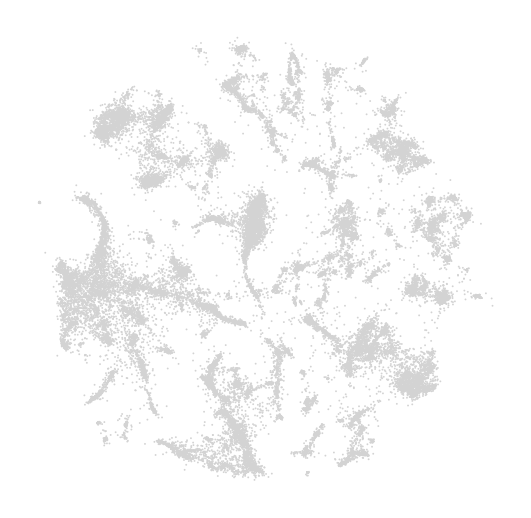

In [58]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    frameon=False,
    ncols=1,
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


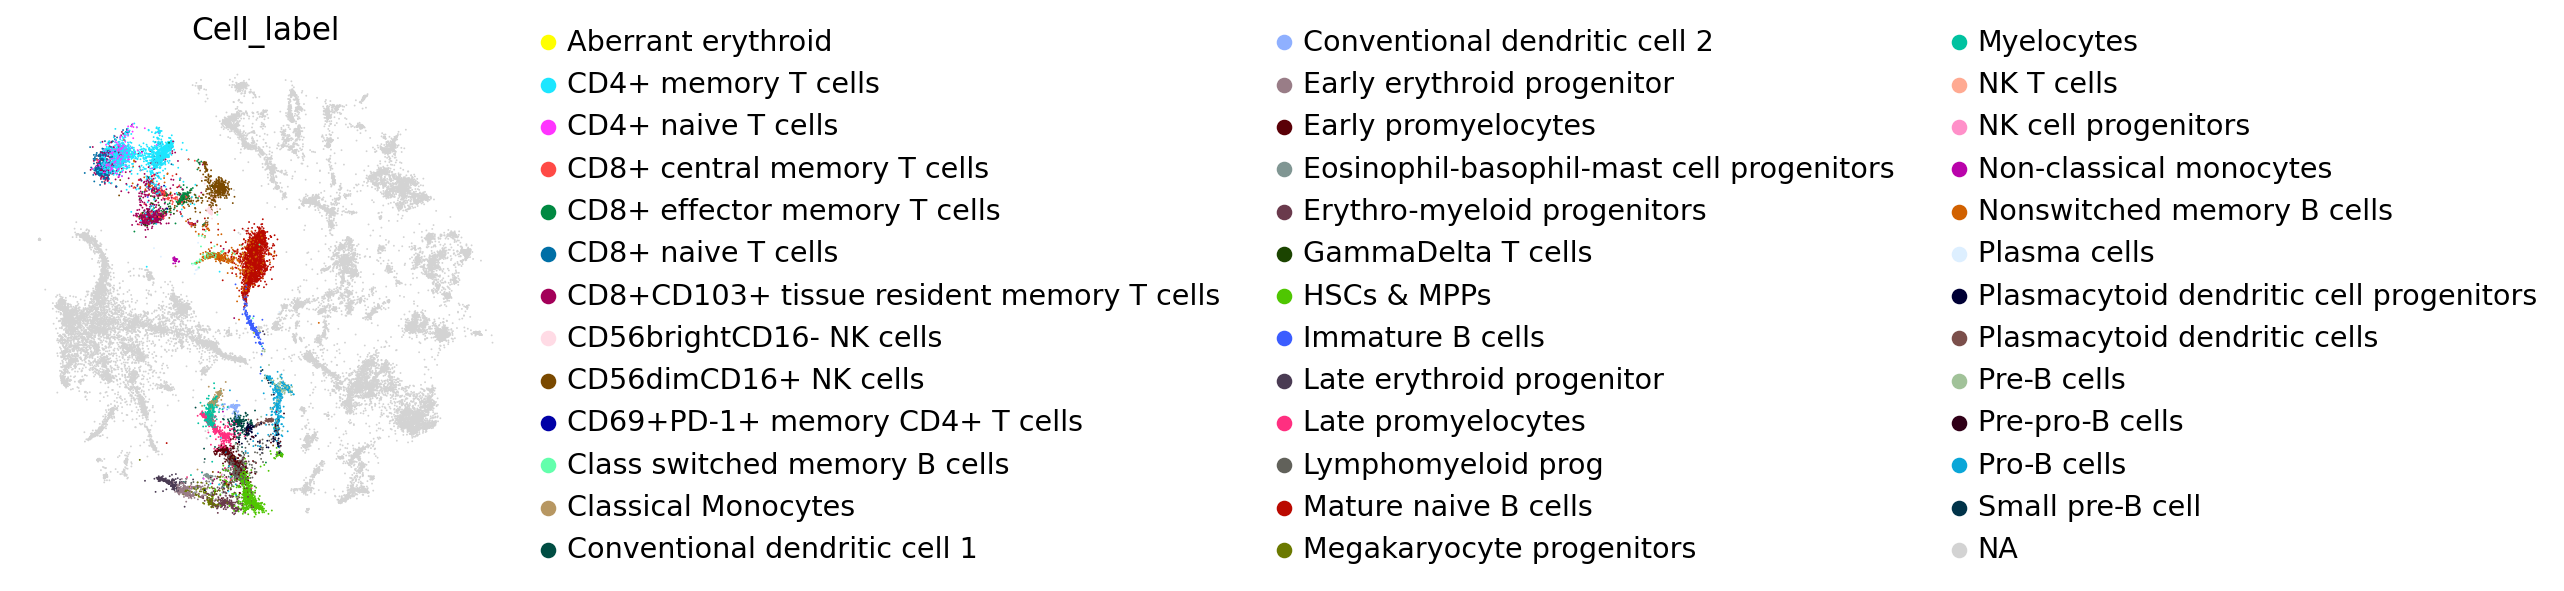

In [59]:
sc.pl.embedding(adata, color="Cell_label", frameon=False, basis="X_mde")

In [60]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

**Transfer of annotations with scANVI**

**scANVI labels**

In [61]:
adata.obs["celltype_scanvi"] = "Unknown"

In [62]:
ref_mask = adata.obs["Genotype"] == "healthy"

In [63]:
adata.obs

,Cluster_ID,donor_id,Cell_label,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,tissue_ontology_term_id,Genotype,development_stage_ontology_term_id,...,RNA_snn_res.5e.04,RNA_snn_res.1,RNA_snn_res.0.4,RNA_snn_res.0.6,RNA_snn_res.0.8,RNA_snn_res.1.4,batch,_scvi_batch,_scvi_labels,celltype_scanvi
884635-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,Unknown
518328-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,Unknown
392962-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,Unknown
826846-0,14,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,Unknown
97453-0,30,BM3,Late erythroid progenitor,True,NCBITaxon:9606,unknown,EFO:0700003,UBERON:0002371,healthy,HsapDv:0000120,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTCTCAGTTCCGTA-1_27_8-1,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,Unknown
TTGAACGTCGAAGTGG-1_27_8-1,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,Unknown
TTGCCTGCACACGTGC-1_27_8-1,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,Unknown
TTGCGTCGTACGGTTT-1_27_8-1,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,588.0,605.0,1.0,968.0,1,0,0,Unknown


In [64]:
adata.obs["celltype_scanvi"][ref_mask] = adata.obs.Cell_label[ref_mask].values

/tmp/ipykernel_28/1818466541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["celltype_scanvi"][ref_mask] = adata.obs.Cell_label[ref_mask].values


In [65]:
np.unique(adata.obs["celltype_scanvi"], return_counts=True)

(array(['Aberrant erythroid', 'CD4+ memory T cells', 'CD4+ naive T cells',
        'CD56brightCD16- NK cells', 'CD56dimCD16+ NK cells',
        'CD69+PD-1+ memory CD4+ T cells', 'CD8+ central memory T cells',
        'CD8+ effector memory T cells', 'CD8+ naive T cells',
        'CD8+CD103+ tissue resident memory T cells',
        'Class switched memory B cells', 'Classical Monocytes',
        'Conventional dendritic cell 1', 'Conventional dendritic cell 2',
        'Early erythroid progenitor', 'Early promyelocytes',
        'Eosinophil-basophil-mast cell progenitors',
        'Erythro-myeloid progenitors', 'GammaDelta T cells', 'HSCs & MPPs',
        'Immature B cells', 'Late erythroid progenitor',
        'Late promyelocytes', 'Lymphomyeloid prog', 'Mature naive B cells',
        'Megakaryocyte progenitors', 'Myelocytes', 'NK T cells',
        'NK cell progenitors', 'Non-classical monocytes',
        'Nonswitched memory B cells', 'Plasma cells',
        'Plasmacytoid dendritic cell p

**Since we’ve already trained an scVI model on our data, we will use it as a pretrained model to scANVI.**

In [66]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key="celltype_scanvi",
)

/opt/conda/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 27 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/opt/conda/lib/python3.10/site-packages/scvi/data/fields/_scanvi.py:58: UserWarning: Category 27 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [71]:
lvae.train(max_epochs=200, n_samples_per_label=100)

INFO     Training for 200 epochs.                                                                                  


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 200/200: 100%|██████████| 200/200 [45:10<00:00, 13.55s/it, v_num=1, train_loss_step=3.46e+3, train_loss_epoch=3.9e+3]


**Now we can predict the missing cell types, and get the latent space**

In [72]:
adata.obs["C_scANVI"] = lvae.predict(adata)
#adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [73]:
latent = lvae.get_latent_representation(adata)

In [74]:
adata.obsm["X_scANVI"] = latent

**Again, we may visualize the latent space as well as the inferred labels**

In [75]:
adata.obsm["X_mde_scanvi"] = mde(adata.obsm["X_scANVI"])

Jul 02 09:57:04 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jul 02 09:57:04 PM: The following items have duplicates [25405 25406 26353 40543 40547 40590 40629 40677 40690 40791 40817 40821
 40913 40915 40943 40990 41067 41078 41170 41204 41207 41213]


... storing 'celltype_scanvi' as categorical
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


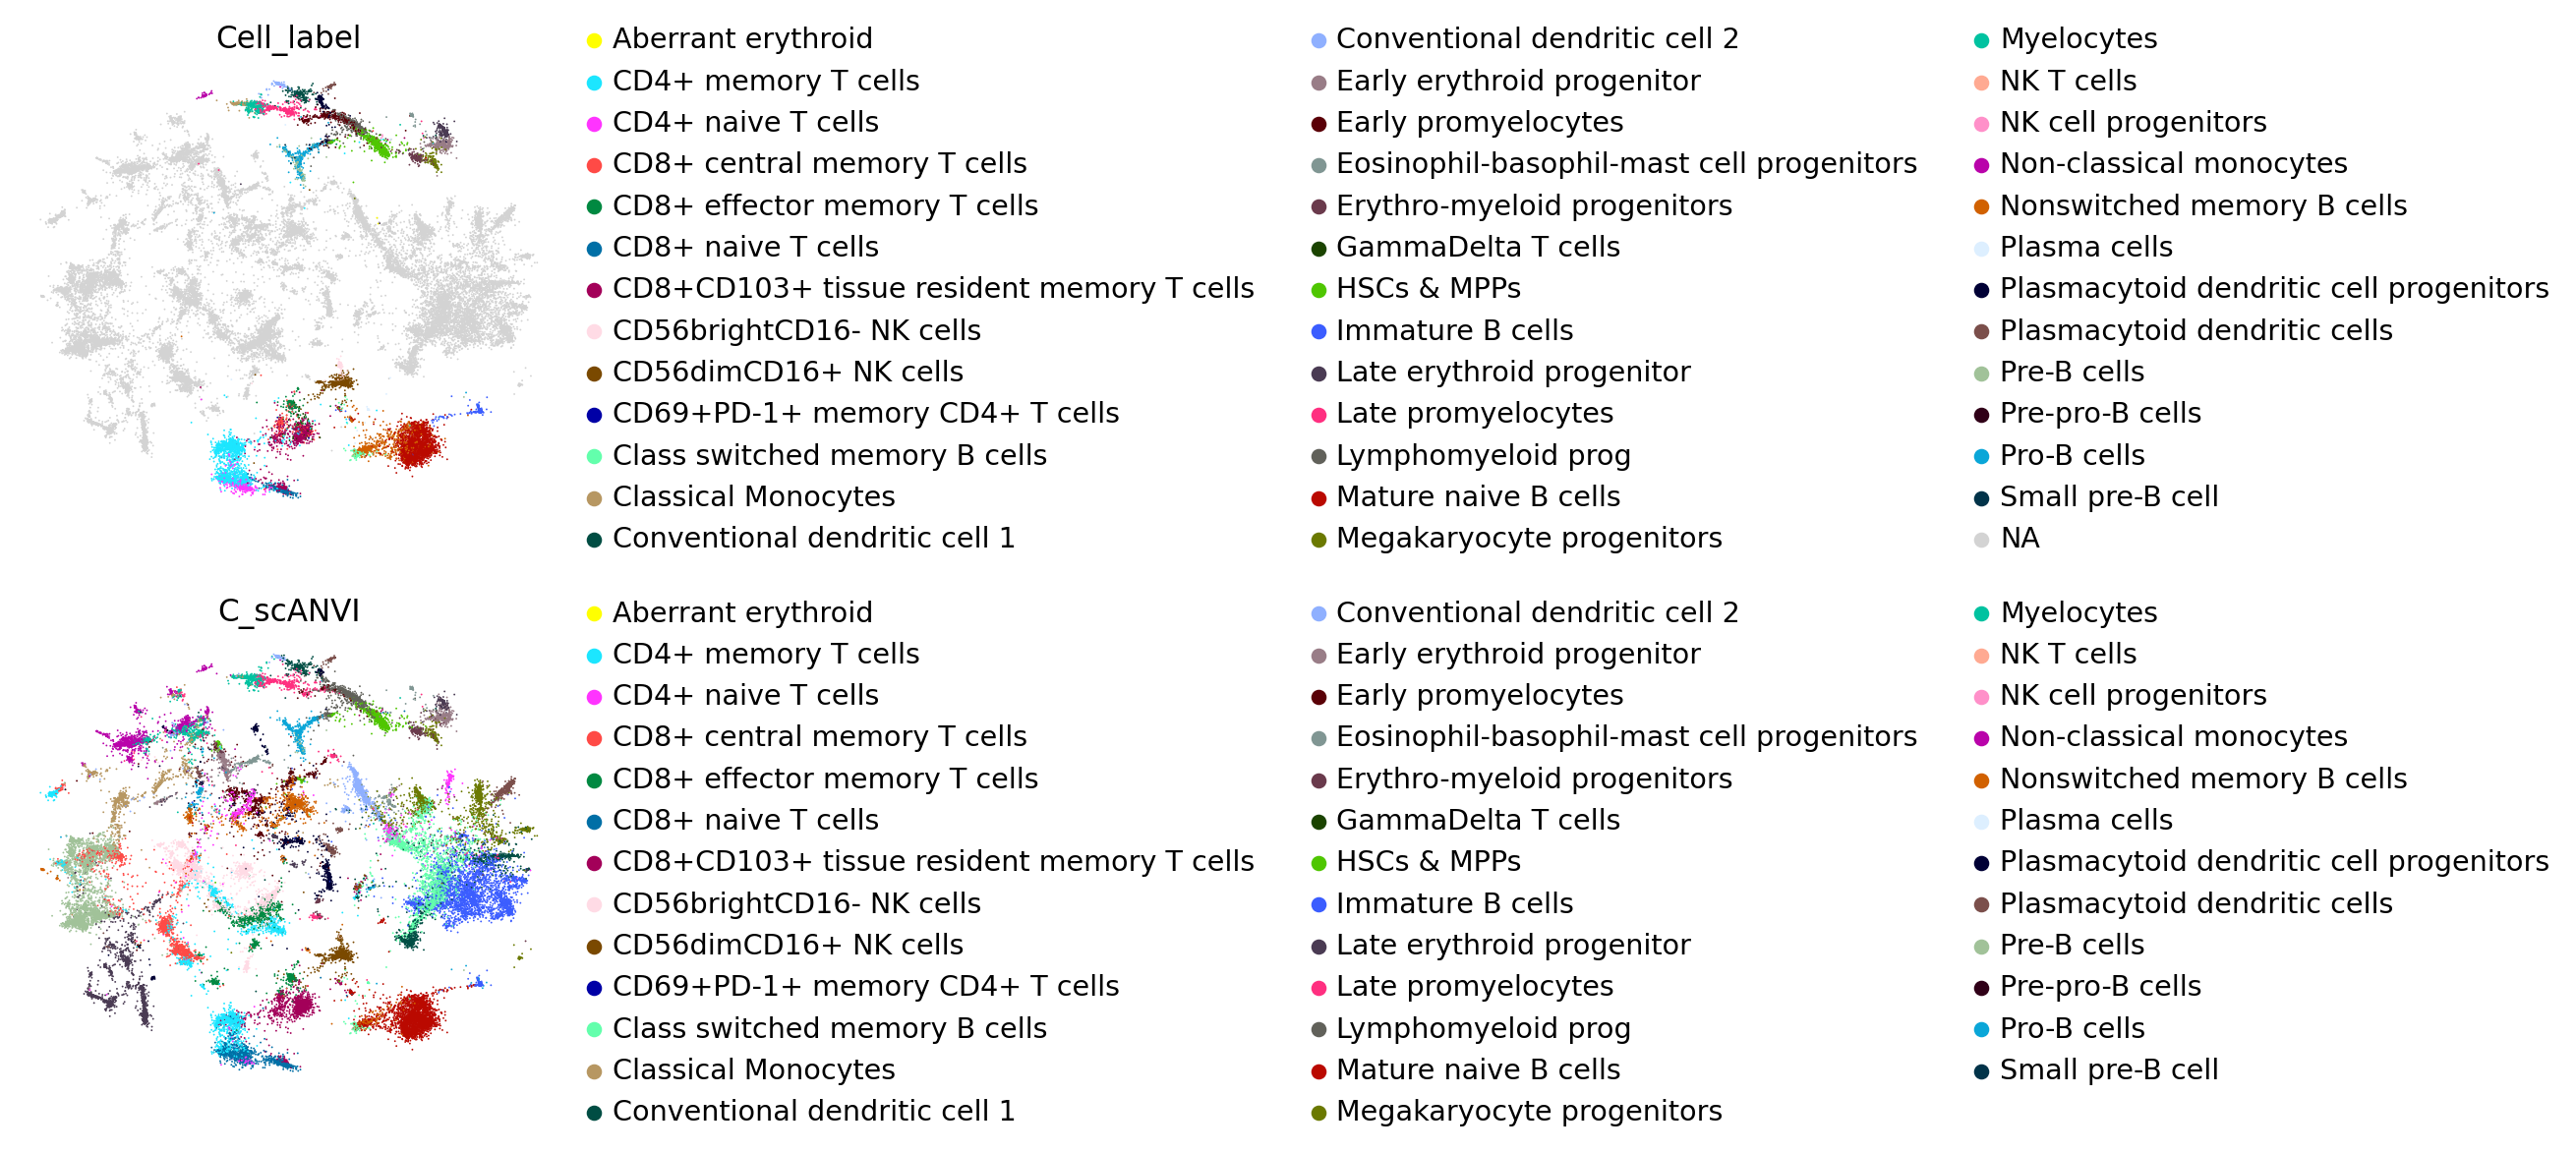

In [76]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.Cell_label.cat.categories
)
sc.pl.embedding(
    adata,
    basis="X_mde_scanvi",
    color=["Cell_label", "C_scANVI"],
    ncols=1,
    frameon=False,
    palette=adata.uns["Cell_label_colors"],
)

**Now we can observe scANVI’s performance using a confusion matrix.******

In [77]:
df = adata.obs.groupby(["Cell_label", "C_scANVI"]).size().unstack(fill_value=0)

In [78]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

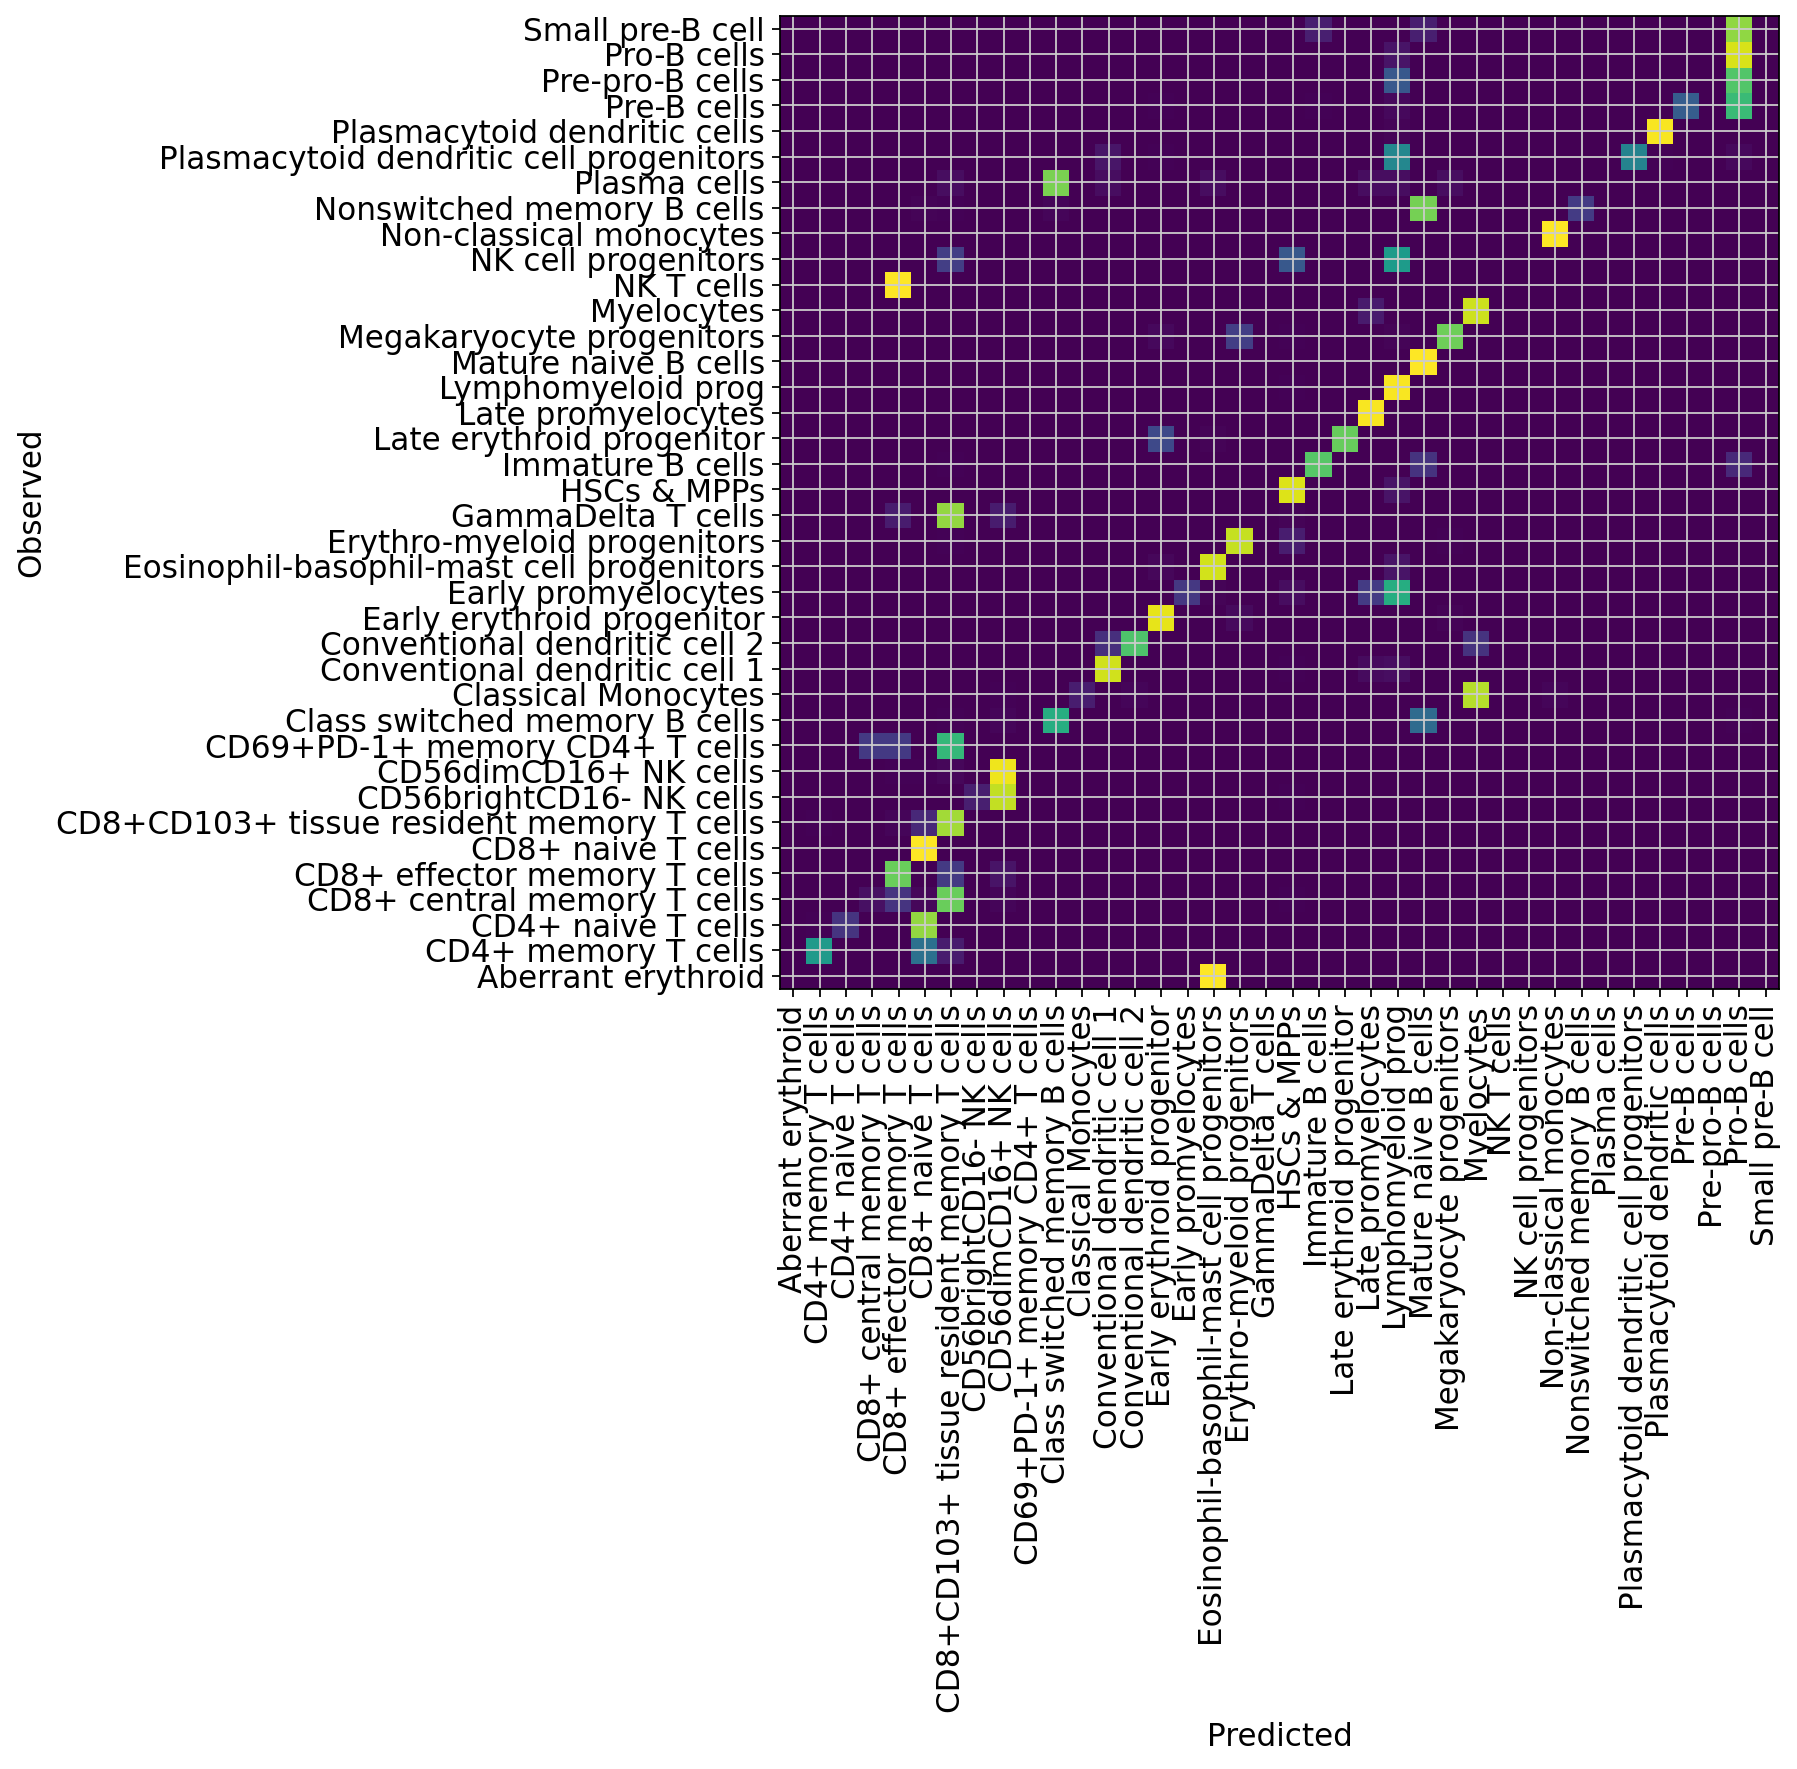

In [79]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")